## Simulation einer PV-Anlage basierend auf pvlib-Bibliotheken
- Methodik auf Grundlage des Jupyter Notebooks von Javier Lopez Lorente, verfügbar unter https://assessingsolar.org/notebooks/solar_power_modeling.html#CharacteristicsPV

![pv_system](./Images/PV-Zentralwechselrichter-System.png "PV-System mit Zentralwechselrichter")

### Charakteristika von Komponenten


- PV Module: Datenbänke von 'The Sandia Laboratories' und 'CEC - California Energy Commission' (Single-Diode Modellierung)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('Y:/masterarbeit/EnQM_control_project')

In [3]:
# Import pvsystem und andere Bibliotheken
from pvlib import pvsystem
from src.data.pycontrolfmu import parse_yaml_config
from src.visualization.methods import create_client
from src.visualization.meteo import get_meteo_solardata, get_temp_data
import pvlib
import numpy as np
import datetime
import math
import pandas as pd

In [4]:
# CEC PV Module
cec_module = pvsystem.retrieve_sam('CECmod')

# Charakteristika von PV-Module in CEC PV Module-Datenbank
print(list(cec_module.iloc[:,0].keys()))

['Technology', 'Bifacial', 'STC', 'PTC', 'A_c', 'Length', 'Width', 'N_s', 'I_sc_ref', 'V_oc_ref', 'I_mp_ref', 'V_mp_ref', 'alpha_sc', 'beta_oc', 'T_NOCT', 'a_ref', 'I_L_ref', 'I_o_ref', 'R_s', 'R_sh_ref', 'Adjust', 'gamma_r', 'BIPV', 'Version', 'Date']


In [5]:
# Sandia PV Module Datenbank
sandia_module = pvsystem.retrieve_sam('sandiamod')

# Charakteristika von PV-Module in CEC PV Module-Datenbank
print(list(sandia_module.iloc[:,0].keys()))

['Vintage', 'Area', 'Material', 'Cells_in_Series', 'Parallel_Strings', 'Isco', 'Voco', 'Impo', 'Vmpo', 'Aisc', 'Aimp', 'C0', 'C1', 'Bvoco', 'Mbvoc', 'Bvmpo', 'Mbvmp', 'N', 'C2', 'C3', 'A0', 'A1', 'A2', 'A3', 'A4', 'B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'DTC', 'FD', 'A', 'B', 'C4', 'C5', 'IXO', 'IXXO', 'C6', 'C7', 'Notes']


PV Module von 'Sandia Laboratories' Datenbank haben mehr technische Parameter als die von 'CEC' Datenbank. Die 'CEC' Datenbank enthält allerdings mehr PV Module.

In [6]:
print('In CEC Datenbank sind insgesamt {}, während in Sandia Datenbank sind {}.'.
      format(cec_module.shape[1], sandia_module.shape[1]))

In CEC Datenbank sind insgesamt 21535, während in Sandia Datenbank sind 523.


#### Bestimmung von PV-Module:

In [7]:
data_mod = cec_module.iloc[:, 100]

In [8]:
data_mod

Technology           Multi-c-Si
Bifacial                      0
STC                     225.129
PTC                       201.1
A_c                       1.616
Length                    1.637
Width                     0.987
N_s                          60
I_sc_ref                   7.97
V_oc_ref                   36.9
I_mp_ref                   7.43
V_mp_ref                   30.3
alpha_sc               0.004411
beta_oc               -0.130387
T_NOCT                     44.5
a_ref                  1.657055
I_L_ref                7.977226
I_o_ref                     0.0
R_s                    0.238429
R_sh_ref             262.963654
Adjust                18.028503
gamma_r               -0.507476
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Advanced_Renewable_Energy_AREi_225W_M6_G, dtype: object

Datasheet zum Vergleich unter: http://www.solarhub.com/product-catalog/pv-modules/6-AREi-225W-M6-G-Advanced-Renewable-Energy

- Wechselrichter: Datenbank von'CEC'

In [9]:
inverters = pvsystem.retrieve_sam('CECInverter')

# Charakteristika von Wechselrichter in CECInverter Datenbank
print(list(inverters.iloc[:,0].keys()))

# Insgesamt
print('Es sind insgesamt {} Wechselrichter in CECInverter Datenbank.'.format(inverters.shape[1]))

['Vac', 'Pso', 'Paco', 'Pdco', 'Vdco', 'C0', 'C1', 'C2', 'C3', 'Pnt', 'Vdcmax', 'Idcmax', 'Mppt_low', 'Mppt_high', 'CEC_Date', 'CEC_Type']
Es sind insgesamt 3264 Wechselrichter in CECInverter Datenbank.


In [10]:
# data_inverter = inverters.iloc[:, 1000]
data_inverter = inverters.loc[:, 'Power_One__PVI_6000_OUTD_US_A__208V_']
data_inverter

Vac                          208
Pso                    30.177542
Paco                      6000.0
Pdco                 6267.335938
Vdco                       310.0
C0                     -0.000004
C1                     -0.000006
C2                      0.001075
C3                     -0.000453
Pnt                          1.8
Vdcmax                     480.0
Idcmax                 20.217213
Mppt_low                   100.0
Mppt_high                  480.0
CEC_Date                     NaN
CEC_Type     Utility Interactive
Name: Power_One__PVI_6000_OUTD_US_A__208V_, dtype: object

Datasheet zum Vergleich: https://s3.amazonaws.com/ecodirect_docs/POWER_ONE/PVI-5000_6000-OUTD-US.pdf

### I-V Kennlinie des Moduls

Single-Diode Model: (Quelle: https://pvsc-python-tutorials.github.io/PVSC48-Python-Tutorial/Tutorial%204%20-%20Model%20a%20Module%27s%20Performance.html#single-diode-model-sdm-iv-curve) 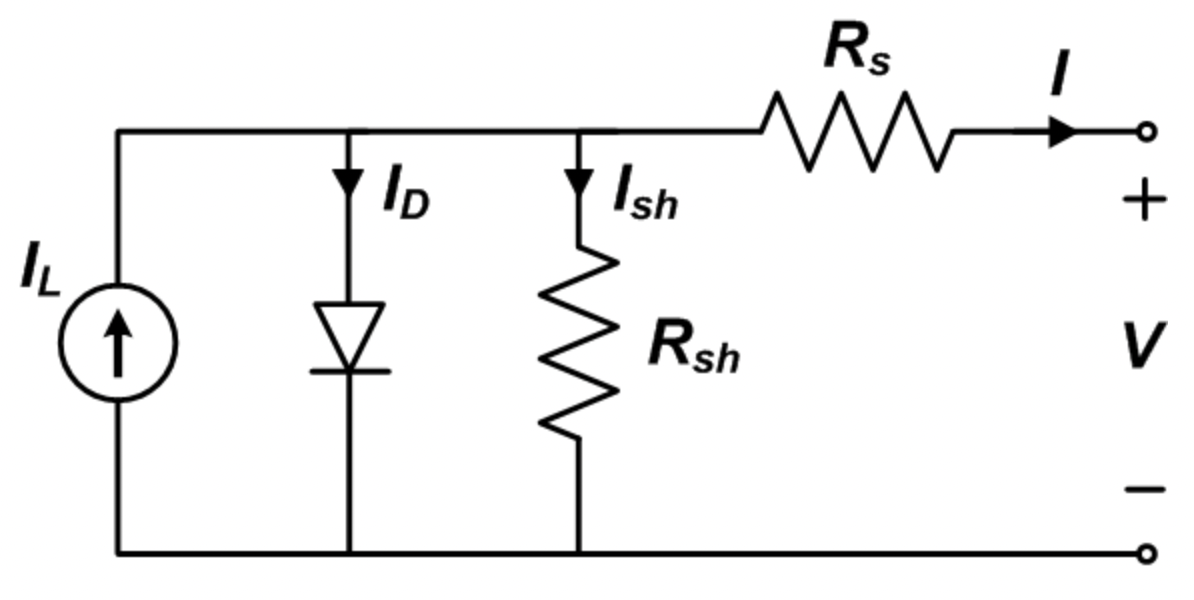

In [11]:
# Datasheet Daten als Dict
if data_mod['Technology'] == 'Multi-c-Si':
    data_mod['Technology'] = 'multi'
module_data = {'celltype':data_mod['Technology'], 'STC':data_mod['STC'], 
               'PTC':data_mod['PTC'], 'v_mp':data_mod['V_mp_ref'], 'i_mp':data_mod['I_mp_ref'],
              'v_oc':data_mod['V_oc_ref'], 'i_sc':data_mod['I_sc_ref'], 
               'alpha_sc':data_mod['alpha_sc'], 'beta_voc':data_mod['beta_oc'], 
              'gamma_pmp':data_mod['gamma_r'], 'cells_in_series':data_mod['N_s'],
              'temp_ref':data_mod['T_NOCT']}

In [12]:
module_data

{'celltype': 'multi',
 'STC': 225.129,
 'PTC': 201.1,
 'v_mp': 30.3,
 'i_mp': 7.43,
 'v_oc': 36.9,
 'i_sc': 7.97,
 'alpha_sc': 0.004411,
 'beta_voc': -0.130387,
 'gamma_pmp': -0.507476,
 'cells_in_series': 60,
 'temp_ref': 44.5}

#### Parameter für CEC Single-Diode-Model

In [13]:
cec_fit_params = pvlib.ivtools.sdm.fit_cec_sam(module_data['celltype'], 
                                               module_data['v_mp'], module_data['i_mp'],
                                  module_data['v_oc'], module_data['i_sc'], 
                                               module_data['alpha_sc'],
                                  module_data['beta_voc'], module_data['gamma_pmp'], 
                                  module_data['cells_in_series'], module_data['temp_ref'])
print(cec_fit_params)

(7.973872840888551, 1.2549337057554807e-08, 0.19414354029963743, 399.5337549046198, 1.8214919914313694, 18.835662588808823)


**Bewertung für die I-V-Kurve für bestimmte Einstrahlungswerte und bestimmte Modultemperaturen:**

In [14]:
# Einstrahlungswerte (W/m2)
einstrahl = np.array([300,400,600,800,1000])
# Durschnittliche Modultemperaturen (in Celsius)
temp_cell = np.array([40, 40, 40, 40, 40])

# Die 5 Parameter für Sinple-Diode Model auswerten
diode_params = pvlib.pvsystem.calcparams_cec(einstrahl, temp_cell, module_data['alpha_sc'], cec_fit_params[4], 
                                            cec_fit_params[0], cec_fit_params[1], cec_fit_params[3], 
                                            cec_fit_params[2], cec_fit_params[5])

# The result of the function returns a Tuple of 5 parameters to be used in the single diode equation
print('Anzahl an Parameter: ', len(diode_params))
print(diode_params)

Anzahl an Parameter:  5
(array([2.40827257, 3.21103009, 4.81654513, 6.42206018, 8.02757522]), array([1.38890816e-07, 1.38890816e-07, 1.38890816e-07, 1.38890816e-07,
       1.38890816e-07]), 0.19414354029963743, array([1331.77918302,  998.83438726,  665.88959151,  499.41719363,
        399.5337549 ]), array([1.9131317, 1.9131317, 1.9131317, 1.9131317, 1.9131317]))


In [15]:
# Single Diode Gleichung
# ivcurve_pnts : Anzahl an Stellen für die I-V Kurve
# method: Methode zur Berechnung ('lambertw', 'newton', oder 'brentq')
iv_data = pvlib.pvsystem.singlediode(diode_params[0], 
                                        diode_params[1], 
                                        diode_params[2], 
                                        diode_params[3], 
                                        diode_params[4], 
                                        ivcurve_pnts=25,   
                                        method='lambertw') 

# Ergebnisse als Dictionary
print(iv_data.keys())

odict_keys(['i_sc', 'v_oc', 'i_mp', 'v_mp', 'p_mp', 'i_x', 'i_xx', 'v', 'i'])


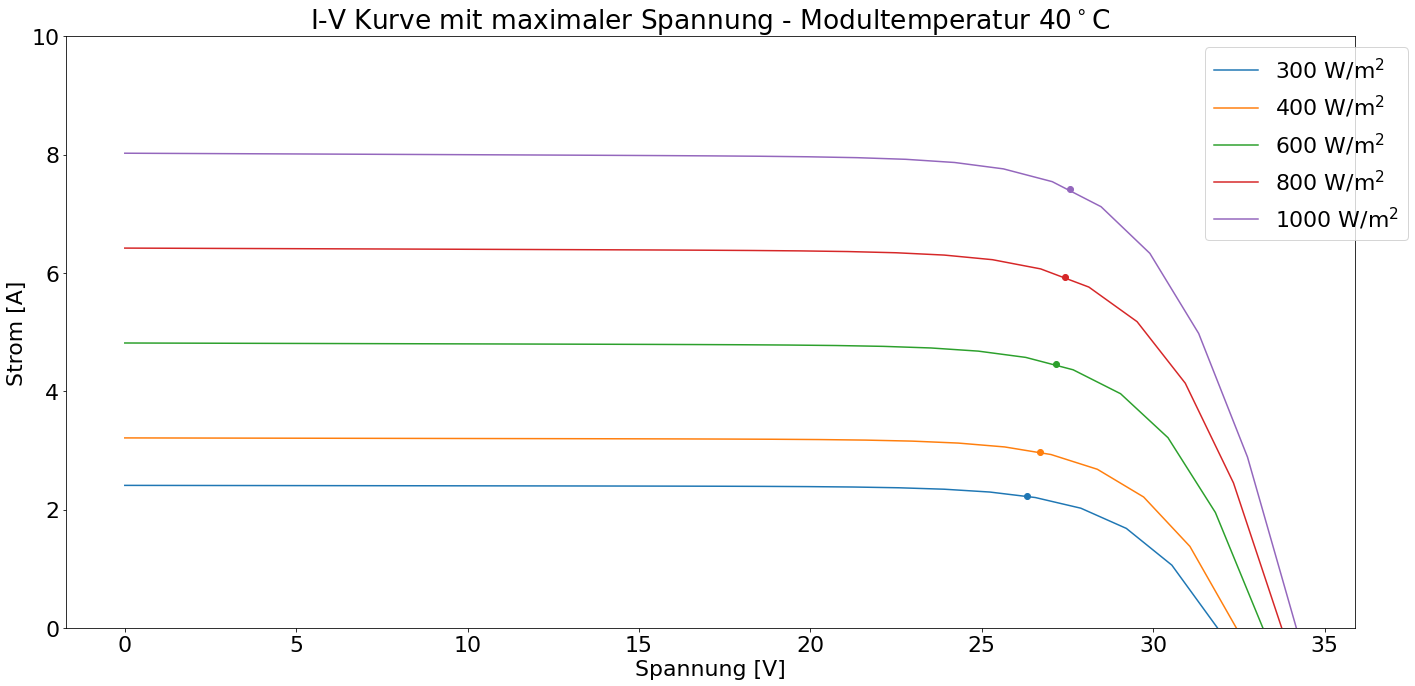

In [16]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.size'] = '22'

# Loop für die Spannung
for i in range(len(einstrahl)):
    plt.plot(iv_data['v'][i], iv_data['i'][i], label=str(einstrahl[i])+' W/m$^2$')
    plt.scatter(iv_data['v_mp'][i], iv_data['i_mp'][i])
    
# Titel, Label und Legende hinzufügen
plt.title('I-V Kurve mit maximaler Spannung - Modultemperatur 40$^\circ$C')
plt.xlabel('Spannung [V]')
plt.ylabel('Strom [A]')
plt.ylim(0, 10)
plt.legend(bbox_to_anchor=(1.05, 1), ncol=1)

#### Effekt von Modultemperatur

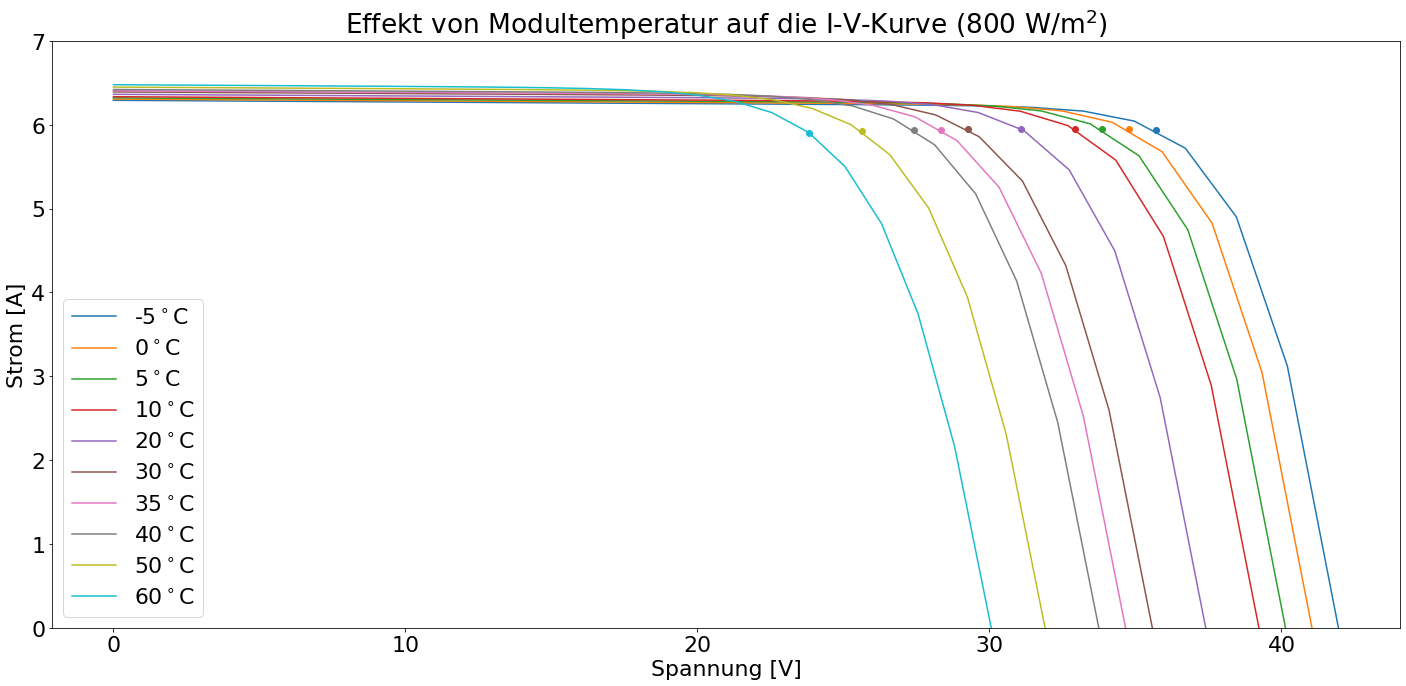

In [17]:
einstrahl = np.array([800, 800, 800, 800, 800, 800, 800, 800, 800, 800])
temp_cell = np.array([-5, 0, 5, 10, 20, 30, 35, 40, 50, 60])
diode_params = pvlib.pvsystem.calcparams_cec(einstrahl, temp_cell, module_data['alpha_sc'], cec_fit_params[4], 
                                            cec_fit_params[0], cec_fit_params[1], cec_fit_params[3], 
                                            cec_fit_params[2], cec_fit_params[5])
iv_data2 = pvlib.pvsystem.singlediode(diode_params[0], 
                                        diode_params[1], 
                                        diode_params[2], 
                                        diode_params[3], 
                                        diode_params[4], 
                                        ivcurve_pnts=25,   # Number of points of the I-V curve (equally distributed)
                                        method='lambertw') # I-V using the Lambert W. function
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.size'] = '22'
for i in range(len(einstrahl)):
    plt.plot(iv_data2['v'][i], iv_data2['i'][i], label=str(temp_cell[i])+'$^\circ$C')
    plt.scatter(iv_data2['v_mp'][i], iv_data2['i_mp'][i])
plt.title('Effekt von Modultemperatur auf die I-V-Kurve (800 W/m$^2$)')
plt.xlabel('Spannung [V]')
plt.ylabel('Strom [A]')
plt.ylim(0, 7)
plt.legend(ncol=1)

#### DC-seitiger Stromertrag

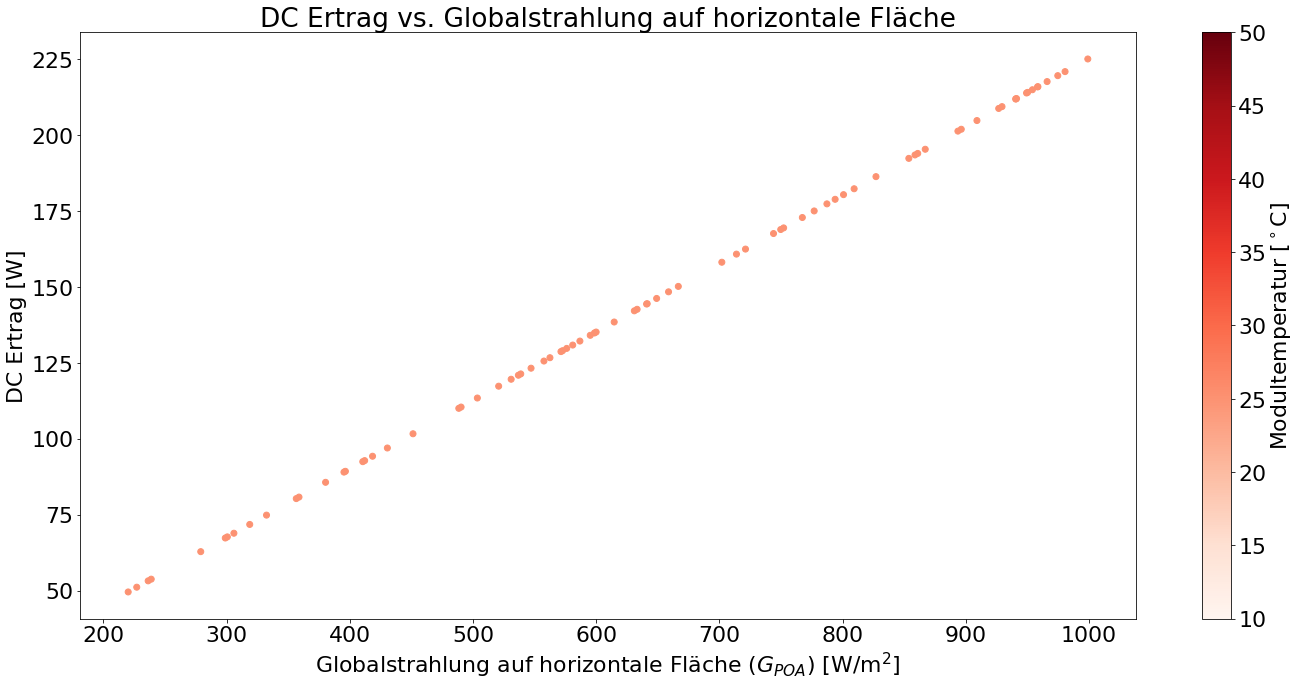

In [18]:
# Beispielswerte für die Globalstrahlung auf die horizontale Fläche und die Modultemperatur mit 25 °C
g_poa_effective = np.random.uniform(low=200, high=1000, size=(80,))
temp_cell = np.repeat(25, 80)  

# PV Charakteristika
pdc0 = module_data['STC']
gamma_pdc = module_data['gamma_pmp']

# Bestimmung der DC-Leistung mittels PVWatts model von pvlib
dc_power = pvlib.pvsystem.pvwatts_dc(g_poa_effective, temp_cell, pdc0, gamma_pdc, temp_ref=25.0)


plt.scatter(g_poa_effective, dc_power, c=temp_cell, vmin=10, vmax=50, cmap='Reds')
cbar = plt.colorbar()
cbar.set_label('Modultemperatur [$^\circ$C]')
plt.title('DC Ertrag vs. Globalstrahlung auf horizontale Fläche')
plt.xlabel('Globalstrahlung auf horizontale Fläche ($G_{POA}$) [W/m$^2$]')
plt.ylabel('DC Ertrag [W]')
plt.show()

Bemerkenswert ist das lineare Verhältnis zwischen der Globalstrahlung auf die horizontale Fläche und dem DC-seitugen Ertrag.

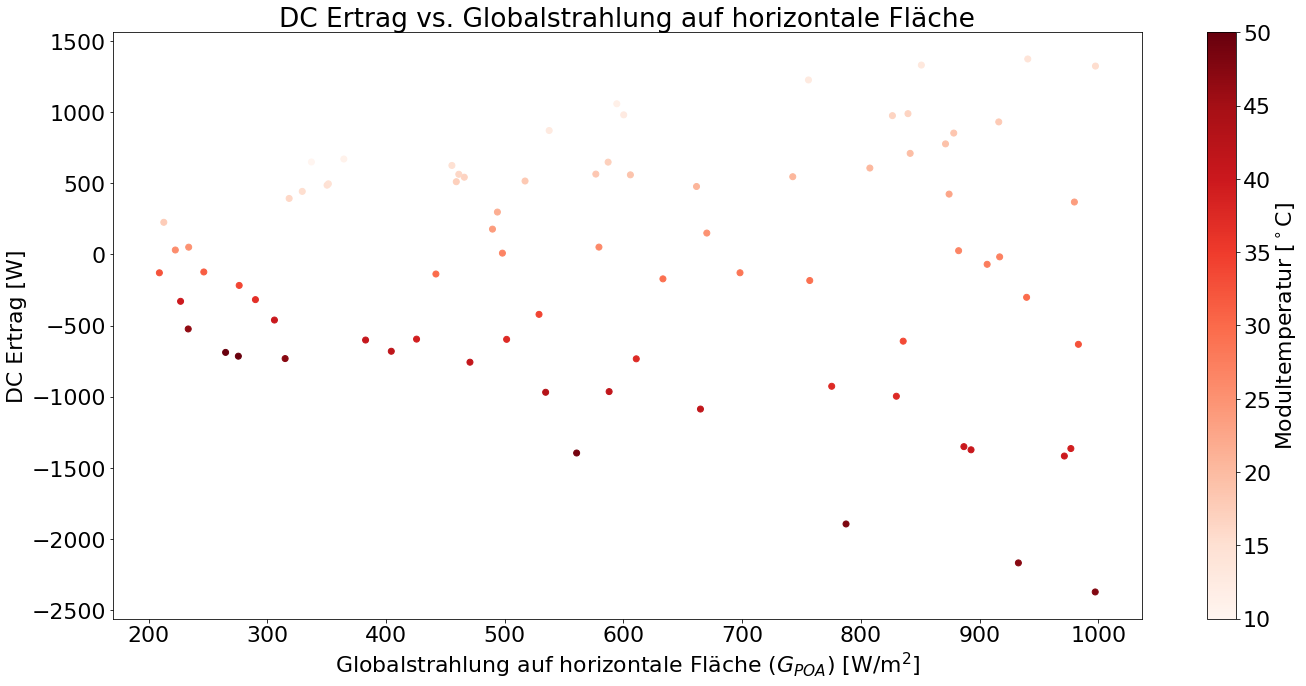

In [19]:
# Beispielswerte für die Globalstrahlung auf die horizontale Fläche und die Modultemperatur
g_poa_effective = np.random.uniform(low=200, high=1000, size=(80,))
temp_cell = np.random.uniform(low=10, high=50, size=(80,)) 
# PV Charakteristika
pdc0 = module_data['STC']
gamma_pdc = module_data['gamma_pmp']
# Bestimmung der DC-Leistung mittels PVWatts model von pvlib
dc_power = pvlib.pvsystem.pvwatts_dc(g_poa_effective, temp_cell, pdc0, gamma_pdc, temp_ref=25.0)
plt.scatter(g_poa_effective, dc_power, c=temp_cell, vmin=10, vmax=50, cmap='Reds')
cbar = plt.colorbar()
cbar.set_label('Modultemperatur [$^\circ$C]')
plt.title('DC Ertrag vs. Globalstrahlung auf horizontale Fläche')
plt.xlabel('Globalstrahlung auf horizontale Fläche ($G_{POA}$) [W/m$^2$]')
plt.ylabel('DC Ertrag [W]')
plt.show()

Effekt der Modultemperatur auf den Ertrag: je die Modultemperatur hoch ist, desto niedrig ist der Ertrag.

#### Zentralwechselrichter: DC -> AC

In [20]:
# Mittels Sandia Models den AC-seitigen Ertrag berechnen
ac_power = pvlib.inverter.sandia(iv_data['v_mp'], # DC-seitige Input-Spannung
                                 iv_data['p_mp'], # DC-seitige Input-Leistung
                                 data_inverter) # Parameters für den Wechselrichter 
# Berechnete elektrische Leistung in Watts
ac_power

array([ 36.96658689,  57.32517036,  98.38895247, 139.54443053,
       180.5479807 ])

##### Eigenverbrauch des Wechselrichters: 

In [21]:
# Effekt von Globaleinstrahlung im Verhältnis zur Auswahl des Wechselrichters...   
data_inverter['Pso']

30.177542

### ModelChain für das gesamte PV-Module-Wechselrichter-System

- Mit dem ModelChain kann man den Ertrag für die Margarethenhöhe mit dem ausgewählten System bestimmen. Hierbei wird die Oberflächenneigung 30° und der Azimutwinkel 180° (Südausrichtung) ausgewählt.
- Zur Bestimmung der Modultemperatur wird den Typ der Dachmontage von pvlib-Funktion 'TEMPERATURE_MODEL_PARAMETERS' benötigt. Die Typische Dachmontage für Installationen in Wohngebäuden ist 'close_mount_glass_glass' - Quelle: https://sam.nrel.gov/forum/forum-general/1040-mount-types.html
- Die verfügbare Dachfläche einschränkt die Anzahl an Modulen, diese wird für das Gebäude-ID-Nr. 4 eingeschätzt.

In [22]:
# Gebäude-Informationen aus einer Excel-Datei ziehen:
df_gebaeude_infos = pd.read_excel('Data/smartm_buildings_infos.xlsx', sheet_name='smartm_build_infos')

In [23]:
df_gebaeude_infos[df_gebaeude_infos['ID']==4]

,ID,Wohnfläche [m^2],Nutzungsbezeichnung,Anbausituation,Anzahl Wohneinheiten,Bauphase,Gebäudehöhe [m],Grundfläche Gebäude [m^2],PV-Eignung
3,4,228.35,Wohnungen,Freistehend,5,1860 - 1918,9.14,118,1


In [24]:
# Annahme: verfügbare Dachfläche ist 50% von Grundfläche
dach_surface = 0.5*df_gebaeude_infos.loc[3,'Grundfläche Gebäude [m^2]']
print("Dachfläche: {} m^2".format(dach_surface))

Dachfläche: 59.0 m^2


In [25]:
# Fläche des Solarmoduls:
modul_surface = data_mod['A_c']
print("Fläche eines Solarmoduls: {} m^2".format(modul_surface))

Fläche eines Solarmoduls: 1.616 m^2


In [26]:
print("Maximale Anzahl an Modulen:", math.ceil(dach_surface/modul_surface))

Maximale Anzahl an Modulen: 37


### Bestimmung des PV-Systems

###### Maximale Anzahl an Modulen in Reihe

Das Wechselrichter-Datasheet gibt eine maximale MPPT Eingangsspannung von 530V. Mit diesem Wert können wir die maximale Anzahl an Modulen in Reihe berechnen. Außerdem ist die Maximale Modulspannung bei der niedrigsten Modultemperatur. 

In [27]:
max_mppt_spannung = 530

In [28]:
# Niedrigste Temperatur in der Margarethenhöhe // Annahme: Modultemperatur = Außenlufttemperatur
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2021, 1, 1)
data = get_temp_data(start, end)
min_temp = min(data['temp'])
print("Niedrigste Außenlufttemperatur: {} °C".format(min_temp))

Niedrigste Außenlufttemperatur: -3.7 °C


Weitere Berechnung mit einer niedrigsten von -5 °C! 
- Die entsprechende Leerlaufspannung berechnet hierbei mit einer Einschtrahlung von 800 W/m2 (Siehe Grafiken oben).

In [29]:
V_modul_max = max(iv_data2['v'][0])
# Somit berechnet man die maximale Anzahl an Modulen in Reihe:
max_module_reihe = max_mppt_spannung / V_modul_max
print("Maximale Anzahl an Modulen in Reihe: {}".format(math.ceil(max_module_reihe)))

Maximale Anzahl an Modulen in Reihe: 13


Gleichfalls berechnet man die minimale Anzahl an Modulen in Reihe:

In [30]:
max_temp = max(data['temp'])
print("Höchste Außenlufttemperatur: {} °C".format(max_temp))

Höchste Außenlufttemperatur: 34.4 °C


In [31]:
# Mit 35°C höchster Außenlufttemperatur
min_mppt_spannung = 200
V_modul_min = max(iv_data2['v'][6])
min_module_reihe = min_mppt_spannung / V_modul_min
print("Maximale Anzahl an Modulen in Reihe: {}".format(math.ceil(min_module_reihe)))

Maximale Anzahl an Modulen in Reihe: 6


Die Anzahl an Modulen in Reihe muss dann zwischen 6 und 13 Module sein.

###### Maximale Anzahl an Modulen in parallel

Der Wechselrichter hat einen maximalen Eingangsstrom von 36 A. Bei 1000 W/m2 ist ein Kurzschlussstrom von etwa 8A. 

In [32]:
# Sei p Anzahl an Modulen in parallel
max_module_parallel = 36/8
print("Maximale Anzahl an Modulen in parallel: {}".format(math.ceil(max_module_parallel)))

Maximale Anzahl an Modulen in parallel: 5


Somit wird entschieden für 3 Module in parallel und 10 Module in Reihe!

In [33]:
reihe = 10
parallel = 3 

In [34]:
# Koordinaten der Margarethenhöhe, Essen
latitude = 51.431207
longitude = 6.977521
altitude = 105 
# Standort-Objekt
location = pvlib.location.Location(latitude, longitude, altitude=altitude)
# Modultempratur mittels TEMPERATURE_MODEL_PARAMETERS von pvlib: 
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['close_mount_glass_glass']
# PVSystem Definieren
system = pvlib.pvsystem.PVSystem(surface_tilt=30, surface_azimuth=180, modules_per_string=reihe, strings_per_inverter=parallel,
                                 module_parameters=data_mod,
                                 inverter_parameters=data_inverter,
                                 temperature_model_parameters=temperature_model_parameters)
# ModelChain objekt erstellen mit Spektrale Verluste und Verluste aufgrund des Einfallswinkels
mc = pvlib.modelchain.ModelChain(system, location, 
                                 aoi_model='physical',
                                 spectral_model='no_loss',
                                 name='PV-Anlage-Margarethenhoehe')
# ModelChain
print(mc)

ModelChain: 
  name: PV-Anlage-Margarethenhoehe
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses


##### Wetterdaten:

In [35]:
_, _, url, key = parse_yaml_config().values()
# API client
client = create_client(url=url, key=key)
df = get_meteo_solardata('2020-01-01', '2020-12-31', '1hour', client=client)
df['zeitstempel'] = df.apply(lambda row : row[0][:21], axis=1)
df.iloc[10,]

zeitstempel      2020-01-01T10:00:00.0
TOA                           342.3474
GHI_clear_sky                 229.2721
BHI_clear_sky                 174.5466
DHI_clear_sky                  54.7255
BNI_clear_sky                 717.1707
GHI                           211.7011
BHI                           169.6223
DHI                            42.0788
BNI                           696.8666
Reliability                        1.0
Name: 10, dtype: object

In [36]:
df

,zeitstempel,TOA,GHI_clear_sky,BHI_clear_sky,DHI_clear_sky,BNI_clear_sky,GHI,BHI,DHI,BNI,Reliability
0,2020-01-01T00:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2020-01-01T01:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2020-01-01T02:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2020-01-01T03:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2020-01-01T04:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
8779,2020-12-31T19:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8780,2020-12-31T20:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8781,2020-12-31T21:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8782,2020-12-31T22:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [37]:
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2021, 1, 1)
data = get_temp_data(start, end)
df_temp_wind = data['temp']
df_temp_wind = df_temp_wind.to_frame(name=None)
df_temp_wind['wind'] = data['wspd'].tolist()
df_temp_wind.reset_index(inplace=True)
df_temp_wind

,time,temp,wind
0,2020-01-01 00:00:00,0.1,8.6
1,2020-01-01 01:00:00,-0.1,8.3
2,2020-01-01 02:00:00,-0.3,8.6
3,2020-01-01 03:00:00,-0.4,8.6
4,2020-01-01 04:00:00,-0.1,9.0
...,...,...,...
8779,2020-12-31 19:00:00,1.5,2.9
8780,2020-12-31 20:00:00,1.6,3.2
8781,2020-12-31 21:00:00,1.8,2.5
8782,2020-12-31 22:00:00,1.8,2.5


In [38]:
df_weather = pd.concat((df, df_temp_wind), axis=1)
df_weather.set_index('zeitstempel', inplace=True)
df_weather = df_weather[['GHI', 'DHI', 'BHI', 'temp', 'wind']]
df_weather.columns = ['ghi', 'dhi', 'dni', 'temp_air', 'wind_speed']
# Einheit der Windgeschwindigkeit anpassen (m/s)
df_weather['wind_speed'] = df_weather['wind_speed']*1000/3600
df_weather.index = pd.to_datetime(df_weather.index)

In [39]:
mc.run_model(df_weather) 

ModelChain: 
  name: PV-Anlage-Margarethenhoehe
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [40]:
# Für pvlib-Simulation benötigte Wetterdata
mc.results.weather

,ghi,dhi,dni,wind_speed,temp_air
zeitstempel,,,,,
2020-01-01 00:00:00,0.0,0.0,0.0,2.388889,0.1
2020-01-01 01:00:00,0.0,0.0,0.0,2.305556,-0.1
2020-01-01 02:00:00,0.0,0.0,0.0,2.388889,-0.3
2020-01-01 03:00:00,0.0,0.0,0.0,2.388889,-0.4
2020-01-01 04:00:00,0.0,0.0,0.0,2.500000,-0.1
...,...,...,...,...,...
2020-12-31 19:00:00,0.0,0.0,0.0,0.805556,1.5
2020-12-31 20:00:00,0.0,0.0,0.0,0.888889,1.6
2020-12-31 21:00:00,0.0,0.0,0.0,0.694444,1.8


#### Darstellung des Ertrags

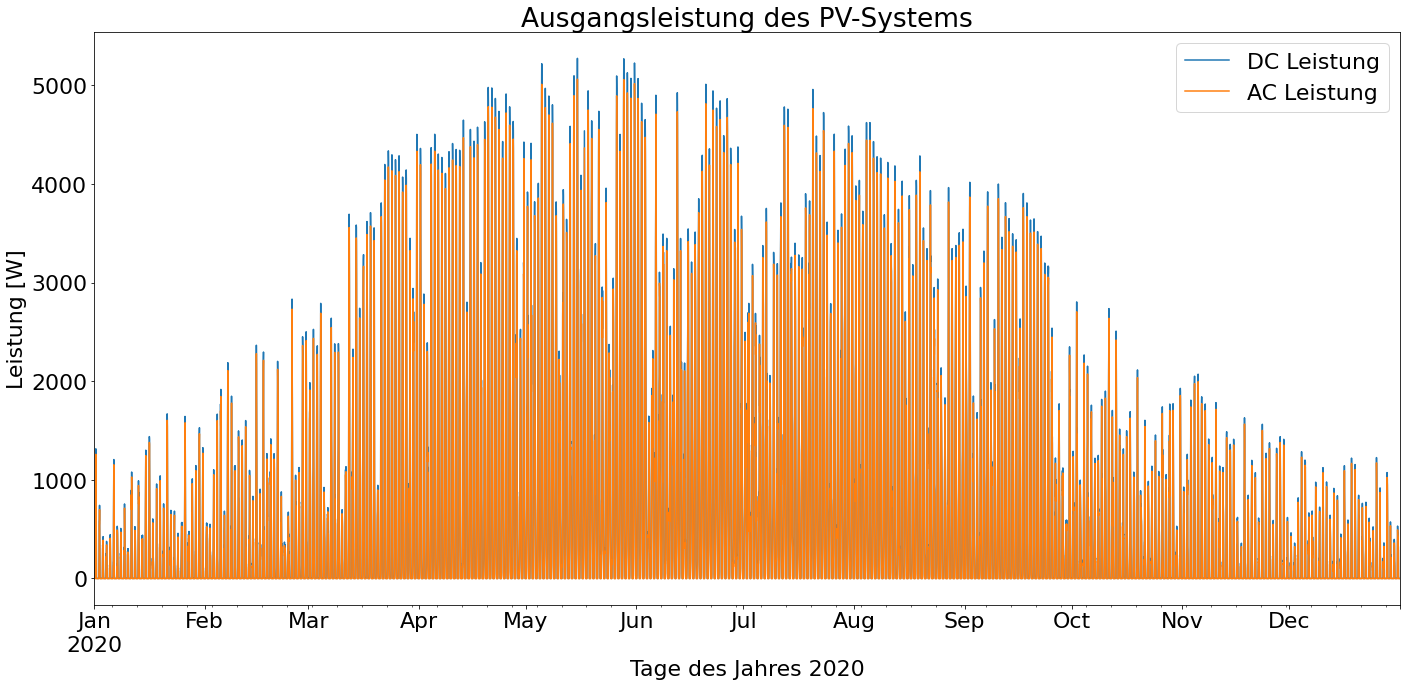

In [41]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.size'] = '22'
fig, ax = plt.subplots()
mc.results.dc['p_mp'].plot(label='DC Leistung')
ax = mc.results.ac.plot(label='AC Leistung')
ax.set_ylabel('Leistung [W]')
ax.set_xlabel('Tage des Jahres 2020')
ax.set_title('Ausgangsleistung des PV-Systems')
plt.legend()
plt.tight_layout()
plt.show() 

In [42]:
# Grobe Einschätzung pro Jahr in kwh
poa_energy = mc.results.total_irrad['poa_global'].sum()/1000 
dc_energy = mc.results.dc['p_mp'].sum()/1000 
ac_energy = mc.results.ac.sum()/1000 
print('*'*15, ' Jahresertrag: ','*'*15,'\n','-'*48) 
print('\tEinstrahlung: ', "%.2f" % poa_energy, 'kWh')
print('\tNennleistung des PV-Systems: ', "%.2f" % float(reihe*parallel*module_data['STC']/1000), 'kW')
print('\tDC Ertrag:', "%.2f" % dc_energy, 'kWh (','%.2f'%(dc_energy*1000/(reihe*parallel*module_data['STC'])), 'kWh/kWp)')
print('\tAC Ertrag:', "%.2f" % ac_energy, 'kWh (','%.2f'%(ac_energy*1000/(reihe*parallel*module_data['STC'])), 'kWh/kWp)')
print('-'*50)

***************  Jahresertrag:  *************** 
 ------------------------------------------------
	Einstrahlung:  1006.78 kWh
	Nennleistung des PV-Systems:  6.75 kW
	DC Ertrag: 6208.42 kWh ( 919.24 kWh/kWp)
	AC Ertrag: 5915.45 kWh ( 875.86 kWh/kWp)
--------------------------------------------------


In [43]:
# Eträge in csv-Datei speichern für Optimierung des Systems
df_ertrag = mc.results.ac
df_ertrag = df_ertrag.to_frame(name='Ertrag [W]')
df_ertrag.index.names = ['Zeitstempel']
df_ertrag.to_csv('Ertrag.csv')